In [ ]:
!pip install konlpy
!pip install wordcloud

!pip install pyLDAvis

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import re
from datetime import datetime
import collections

import requests, json
from bs4 import BeautifulSoup
import urllib.parse as parse

from tqdm import tqdm
import pickle
from pprint import pprint as print

import numpy as np
import pandas as pd
import sklearn as sk

from konlpy.tag import Okt, Komoran # komoran, hannanum, kkma, mecab
import gensim
from gensim.summarization import summarize

# visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis.gensim_models

# 브라우저에서 바로 그려지도록 
# %matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumSquareRound') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# Seaborn 테마 설정
sns.set_theme(style="ticks", color_codes=True, font='NanumSquareRound', font_scale=2)

# 워닝 메세지 삭제
import warnings
warnings.filterwarnings(action='ignore')

# font_list = [font.name for font in fm.fontManager.ttflist]
# font_list

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [2]:
font_list = [font.name for font in fm.fontManager.ttflist]
font_list
path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'

In [3]:
# 피클 사용법
# list = ['a', 'b', 'c']
# with open('list.txt', 'wb') as f:
#   pickle.dump(list, f)

# with open('list.txt', 'rb') as f:
#   data = pickle.load(f)

In [4]:
df = pd.read_csv('러시아 한국 경제_v2_2022041520220224.csv')

In [5]:
def clean_content(content):
  stripped = content[69:-2]
  cleaned = re.sub('[^가-힣ㄱ-ㅣa-zA-Z|0-9.%]', ' ', string=stripped)
  return cleaned

def clean_title(title):
  cleaned = re.sub('[^가-힣ㄱ-ㅣa-zA-Z|0-9.%]', ' ', string=title)
  return cleaned

In [6]:
df['내용'] = df['내용'].apply(clean_content)
df['제목'] = df['제목'].apply(clean_title) + '.'
df['제목내용'] = df['제목'] + ' ' + df['내용']
# df['제목내용'][0]

In [7]:
#@title
# TextRank

# for idx in range(len(df['제목내용'])):
#   try:
#     df['제목내용'].iloc[idx] = summarize(df['제목내용'].iloc[idx], ratio=0.5)
#   except Exception as e:
#     print(idx)
#     print(e)

# df['제목내용'][0]

In [8]:
kmr = Komoran(userdic='user_dictionary.txt')

In [9]:
preprocessed = df['제목내용'].apply(kmr.nouns)

In [10]:
preprocessed

0       [오늘, 점심, 칼국수, 말, 서울, 원, 돌파, 우크라, 사태, 가격, 고공, 행...
1       [우크라, 전쟁, 장기, 농업, 강세, 국제, 곡물, 분기, 상승, 현대, 사료, ...
2       [식량, 자급, 내년, 농촌, 경제, 전망, 농지, 감소, 생산, 기반, 약화, 식...
3       [윤석열, 당선, 경제, 복합, 위기, 징후, 경기, 둔화, 물가, 대책, 주문, ...
4       [미, 동맹, 바탕, 유럽, 아시아, 외교, 확장, 당선, 외신, 인터뷰, 쿼드, ...
                              ...                        
1451    [전국, 신문, 톱뉴스, 일, 조간, 경향신문, 미, 러, 제재, 대화, 문도, 국...
1452    [조간, 브리핑, 신용, 자, 대출, 금리, 고금리, 부담, 시작, 경제와이드 모닝...
1453    [러시아, 전면, 침공, 미, 기준, 금리, 전망, 글로벌, 마켓, 앵커, 오늘, ...
1454    [국제, 유가, 달러, 한국, 성장, 불, 우크라, 사태, 전망, 달러, 전제, 러...
1455    [우크라, 리스크, 원유, 수입, 위, 한국, 문제, 에너지, 러시아, 우크라, 침...
Name: 제목내용, Length: 1456, dtype: object

In [11]:
with open('stopwords.pickle', 'rb') as f:
  stopwords = pickle.load(f)
# stopwords
stopwords.append('일보')
stopwords.append('경남')

In [12]:
len(preprocessed[0])

205

In [13]:
# 불용어 삭제 함수

def sw_rmv(row):
  lst = []
  for el in row:
    if el not in stopwords:
      lst.append(el)
  return lst

In [14]:
preprocessed_ = preprocessed.apply(sw_rmv)

In [15]:
len(preprocessed_[0])

174

In [16]:
# okt = Okt()
# preprocessed = df['제목내용'].apply(okt.morphs, stem= True)

In [17]:
dictionary = gensim.corpora.Dictionary(preprocessed)
# print(dictionary.token2id)
# print('dictionary size : %d' % len(dictionary))

In [18]:
corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in preprocessed]

In [19]:

# for doc in corpus:
#   print([[dictionary[id], freq] for id, freq in doc])
#   print([[id, freq] for id, freq in doc])

In [20]:
tfidf = gensim.models.TfidfModel(corpus, smartirs='ntc')

In [21]:
# doc_lda = lda_model[corpus]
# doc_lda

> ### LDA 토픽 10개

In [22]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [23]:
font_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'

In [24]:
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None

lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf[corpus],
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            chunksize=chunksize,
                                            passes=passes,
                                            iterations=iterations,
                                            eval_every=eval_every)

2022-04-18 07:12:45,825 : INFO : using symmetric alpha at 0.1
2022-04-18 07:12:45,977 : INFO : using symmetric eta at 0.1
2022-04-18 07:12:45,988 : INFO : using serial LDA version on this node
2022-04-18 07:12:46,022 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 1456 documents, updating model once every 1456 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2022-04-18 07:12:48,228 : INFO : PROGRESS: pass 0, at document #1456/1456
2022-04-18 07:12:49,299 : INFO : topic #1 (0.100): 0.001*"곡물" + 0.001*"금리" + 0.001*"물가" + 0.001*"통상" + 0.001*"가격" + 0.001*"유가" + 0.001*"상승" + 0.001*"수입" + 0.001*"총재" + 0.001*"정책"
2022-04-18 07:12:49,302 : INFO : topic #2 (0.100): 0.002*"물가" + 0.001*"금리" + 0.001*"달러" + 0.001*"유가" + 0.001*"원" + 0.001*"기업" + 0.001*"적자" + 0.001*"상승" + 0.001*"무역수지" + 0.001*"회장"
2022-04-18 07:12:49,305 : INFO : topic #0 (0.100): 0.001*"물가" + 0.001*"가격" + 0.001*"달러" + 0.001

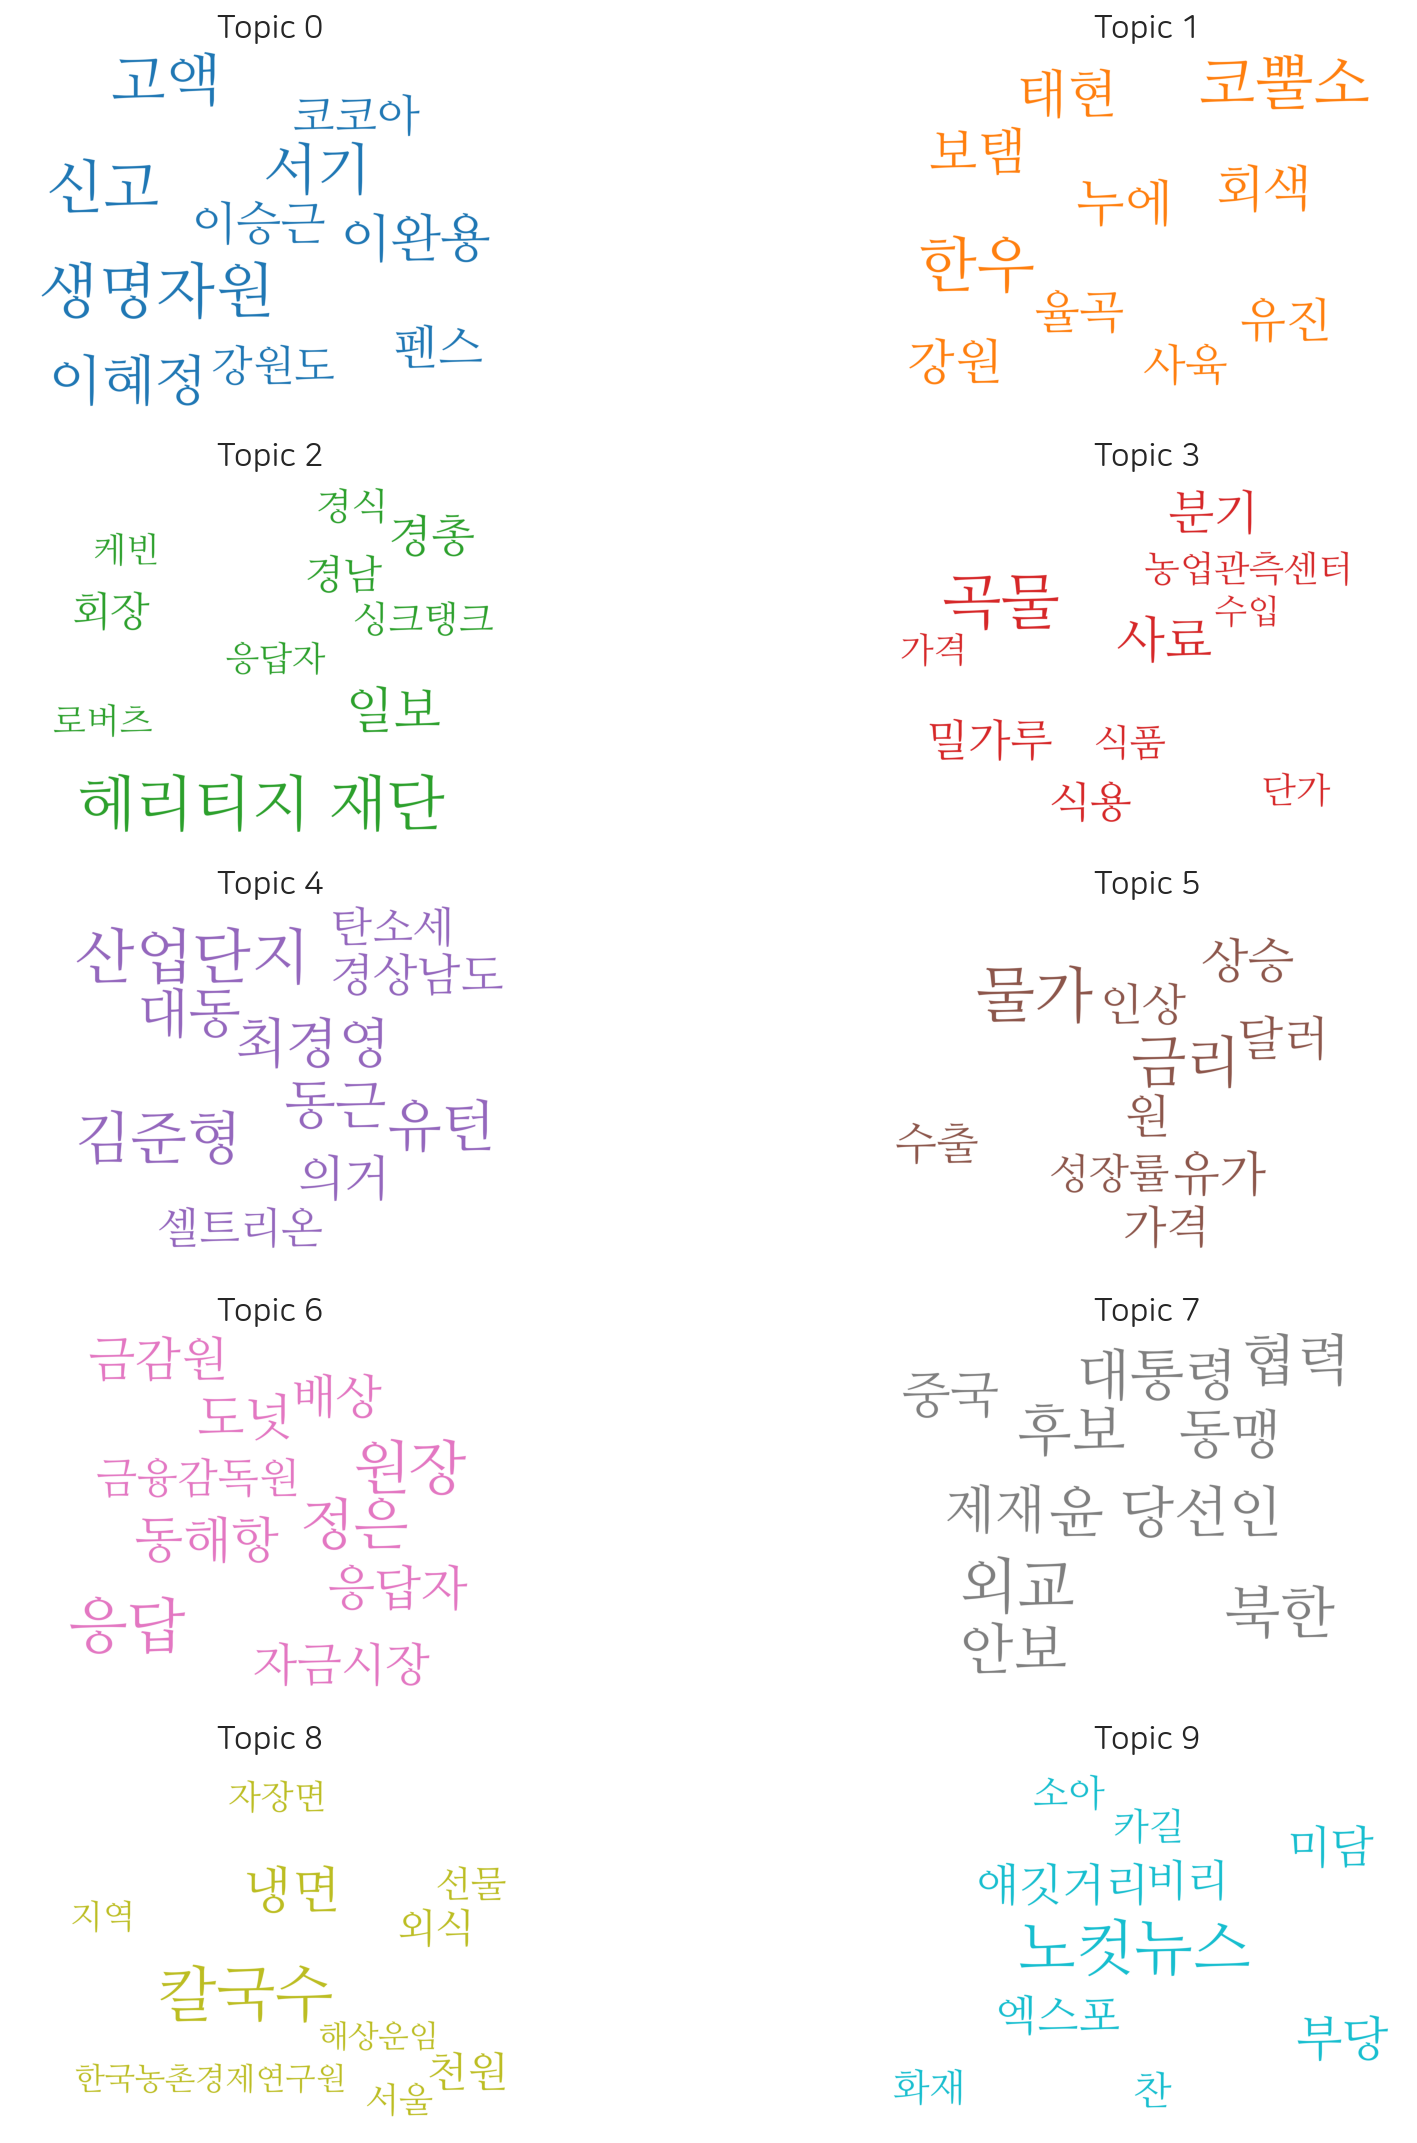

In [25]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0,
                  font_path=font_path)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [26]:
print(lda_model.print_topics())

2022-04-18 07:13:43,253 : INFO : topic #0 (0.100): 0.001*"생명자원" + 0.001*"신고" + 0.001*"고액" + 0.001*"서기" + 0.001*"이혜정" + 0.000*"이완용" + 0.000*"펜스" + 0.000*"이승근" + 0.000*"코코아" + 0.000*"강원도"
2022-04-18 07:13:43,256 : INFO : topic #1 (0.100): 0.001*"한우" + 0.001*"코뿔소" + 0.001*"태현" + 0.000*"보탬" + 0.000*"회색" + 0.000*"누에" + 0.000*"강원" + 0.000*"유진" + 0.000*"율곡" + 0.000*"사육"
2022-04-18 07:13:43,258 : INFO : topic #2 (0.100): 0.002*"헤리티지 재단" + 0.002*"일보" + 0.001*"경총" + 0.001*"회장" + 0.001*"경남" + 0.001*"경식" + 0.001*"싱크탱크" + 0.001*"로버츠" + 0.001*"케빈" + 0.001*"응답자"
2022-04-18 07:13:43,261 : INFO : topic #3 (0.100): 0.009*"곡물" + 0.006*"사료" + 0.005*"분기" + 0.005*"밀가루" + 0.004*"식용" + 0.003*"식품" + 0.003*"농업관측센터" + 0.003*"단가" + 0.003*"가격" + 0.003*"수입"
2022-04-18 07:13:43,263 : INFO : topic #4 (0.100): 0.000*"산업단지" + 0.000*"김준형" + 0.000*"유턴" + 0.000*"최경영" + 0.000*"대동" + 0.000*"동근" + 0.000*"의거" + 0.000*"경상남도" + 0.000*"셀트리온" + 0.000*"탄소세"
2022-04-18 07:13:43,265 : INFO : topic #5 (0.100): 0.004*"물가" + 0.004*"금리"

[(0,
  '0.001*"생명자원" + 0.001*"신고" + 0.001*"고액" + 0.001*"서기" + 0.001*"이혜정" + '
  '0.000*"이완용" + 0.000*"펜스" + 0.000*"이승근" + 0.000*"코코아" + 0.000*"강원도"'),
 (1,
  '0.001*"한우" + 0.001*"코뿔소" + 0.001*"태현" + 0.000*"보탬" + 0.000*"회색" + '
  '0.000*"누에" + 0.000*"강원" + 0.000*"유진" + 0.000*"율곡" + 0.000*"사육"'),
 (2,
  '0.002*"헤리티지 재단" + 0.002*"일보" + 0.001*"경총" + 0.001*"회장" + 0.001*"경남" + '
  '0.001*"경식" + 0.001*"싱크탱크" + 0.001*"로버츠" + 0.001*"케빈" + 0.001*"응답자"'),
 (3,
  '0.009*"곡물" + 0.006*"사료" + 0.005*"분기" + 0.005*"밀가루" + 0.004*"식용" + '
  '0.003*"식품" + 0.003*"농업관측센터" + 0.003*"단가" + 0.003*"가격" + 0.003*"수입"'),
 (4,
  '0.000*"산업단지" + 0.000*"김준형" + 0.000*"유턴" + 0.000*"최경영" + 0.000*"대동" + '
  '0.000*"동근" + 0.000*"의거" + 0.000*"경상남도" + 0.000*"셀트리온" + 0.000*"탄소세"'),
 (5,
  '0.004*"물가" + 0.004*"금리" + 0.003*"유가" + 0.003*"상승" + 0.003*"달러" + 0.003*"원" '
  '+ 0.002*"가격" + 0.002*"인상" + 0.002*"수출" + 0.002*"성장률"'),
 (6,
  '0.002*"응답" + 0.002*"원장" + 0.001*"정은" + 0.001*"도넛" + 0.001*"동해항" + '
  '0.001*"응답자" + 0.001*"금감원" 

In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, tfidf[corpus], dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.237912  0.011007       1        1  64.422371
7     -0.007704 -0.145406       2        1  20.117991
3     -0.024434  0.045160       3        1   3.982865
8     -0.027865  0.024125       4        1   2.446160
6     -0.033289  0.013343       5        1   1.875459
2     -0.032730  0.012918       6        1   1.846077
0     -0.030627  0.011115       7        1   1.544917
9     -0.028302  0.009973       8        1   1.347804
1     -0.028183  0.009754       9        1   1.332282
4     -0.024777  0.008010      10        1   1.084076, topic_info=      Term       Freq      Total Category  logprob  loglift
7       곡물  17.000000  17.000000  Default  30.0000  30.0000
144     분기  16.000000  16.000000  Default  29.0000  29.0000
1       가격  24.000000  24.000000  Default  28.0000  28.0000
158     수입  19.000000  19.000000  Default  27.0000  27.0000
147     사료   5.000000   5.000000  Default  26.0000  26.0000
...    ...        ...        ...      ...      ...      ...
5344    리셋   0.028289   0.343301  Topic10  -8.6385   2.0283
16373   경동   0.024743   0.306595  Topic10  -8.7724   2.0074
7237    수산   0.025690   0.356139  Topic10  -8.7348   1.8952
7479    반값   0.025183   0.384433  Topic10  -8.7548   1.7988
4086    기아   0.024921   0.935148  Topic10  -8.7652   0.8994

[482 rows x 6 columns], token_table=      Topic      Freq Term
term                      
558       1  0.956082   2월
1062      1  1.023411   3월
7267      3  1.289457   90
2574      3  0.964562   가게
1         1  0.895045   가격
...     ...       ...  ...
1608      2  1.095072   회색
1060      1  0.408374   회장
1060      2  0.544499   회장
1320      1  0.314349   후보
1320      2  0.628698   후보

[239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 4, 9, 7, 3, 1, 10, 2, 5])

> ### LDA 토픽 5개

In [28]:
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None

lda_model_5 = gensim.models.ldamodel.LdaModel(corpus=tfidf[corpus],
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            chunksize=chunksize,
                                            passes=passes,
                                            iterations=iterations,
                                            eval_every=eval_every)

2022-04-18 07:13:50,685 : INFO : using symmetric alpha at 0.2
2022-04-18 07:13:50,687 : INFO : using symmetric eta at 0.2
2022-04-18 07:13:50,695 : INFO : using serial LDA version on this node
2022-04-18 07:13:50,710 : INFO : running online (multi-pass) LDA training, 5 topics, 20 passes over the supplied corpus of 1456 documents, updating model once every 1456 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2022-04-18 07:13:52,137 : INFO : PROGRESS: pass 0, at document #1456/1456
2022-04-18 07:13:53,491 : INFO : topic #0 (0.200): 0.001*"제재" + 0.001*"기업" + 0.001*"금리" + 0.001*"달러" + 0.001*"물가" + 0.001*"유가" + 0.001*"가격" + 0.001*"원" + 0.001*"중국" + 0.001*"수출"
2022-04-18 07:13:53,494 : INFO : topic #1 (0.200): 0.002*"물가" + 0.002*"금리" + 0.001*"유가" + 0.001*"달러" + 0.001*"가격" + 0.001*"곡물" + 0.001*"상승" + 0.001*"인상" + 0.001*"총재" + 0.001*"정부"
2022-04-18 07:13:53,498 : INFO : topic #2 (0.200): 0.002*"곡물" + 0.002*"물가" + 0.002*"분기" + 0.002*"금

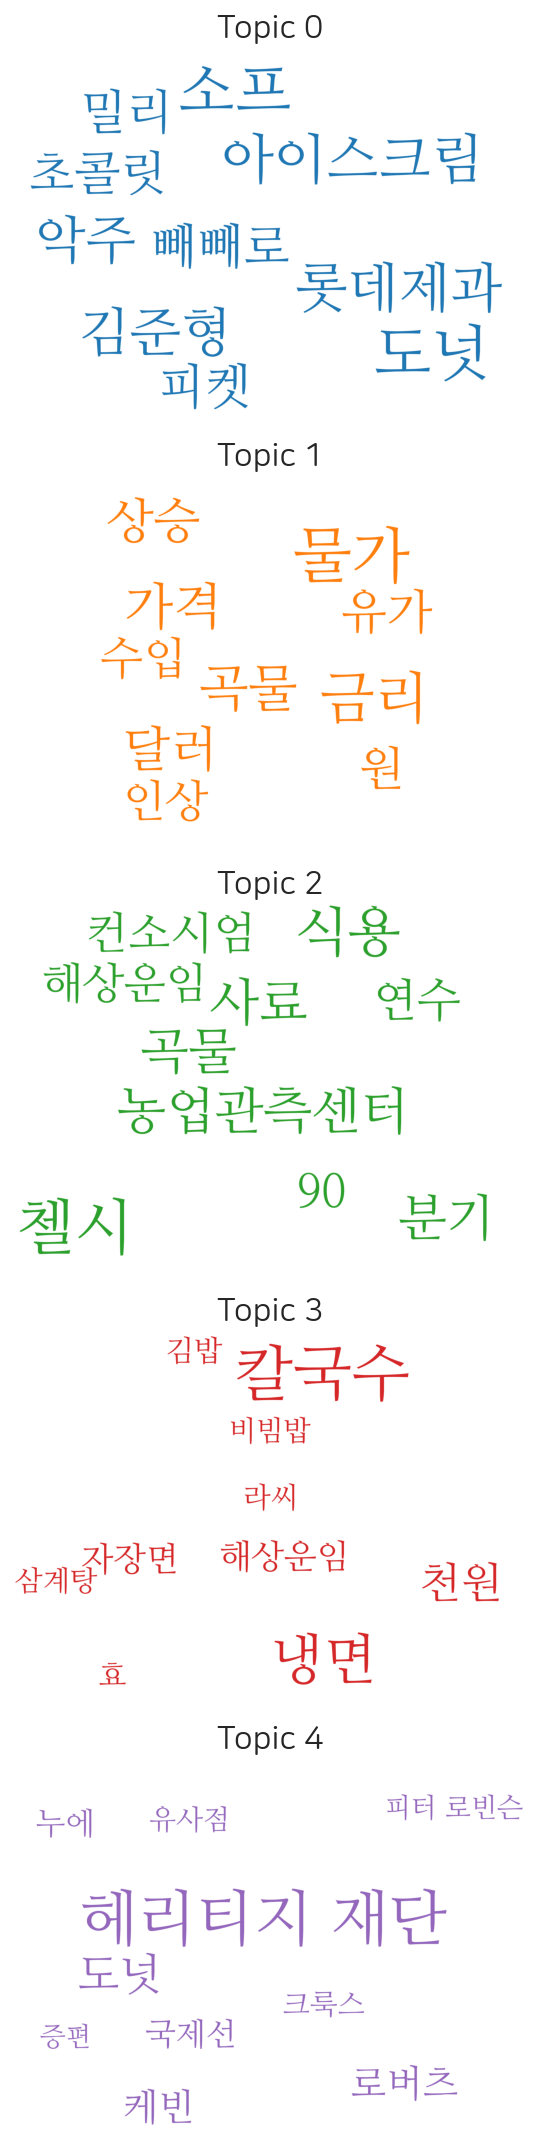

In [29]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0,
                  font_path=font_path)

topics = lda_model_5.show_topics(formatted=False)

fig, axes = plt.subplots(5, 1, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [30]:
print(lda_model_5.print_topics())

2022-04-18 07:14:36,196 : INFO : topic #0 (0.200): 0.000*"도넛" + 0.000*"소프" + 0.000*"아이스크림" + 0.000*"롯데제과" + 0.000*"김준형" + 0.000*"악주" + 0.000*"피켓" + 0.000*"빼빼로" + 0.000*"밀리" + 0.000*"초콜릿"
2022-04-18 07:14:36,200 : INFO : topic #1 (0.200): 0.003*"물가" + 0.002*"금리" + 0.002*"가격" + 0.002*"곡물" + 0.002*"달러" + 0.002*"상승" + 0.002*"유가" + 0.002*"원" + 0.002*"수입" + 0.002*"인상"
2022-04-18 07:14:36,202 : INFO : topic #2 (0.200): 0.001*"첼시" + 0.001*"식용" + 0.001*"사료" + 0.001*"농업관측센터" + 0.001*"분기" + 0.001*"곡물" + 0.001*"90" + 0.001*"연수" + 0.001*"컨소시엄" + 0.001*"해상운임"
2022-04-18 07:14:36,205 : INFO : topic #3 (0.200): 0.003*"칼국수" + 0.002*"냉면" + 0.001*"천원" + 0.001*"해상운임" + 0.001*"자장면" + 0.001*"김밥" + 0.001*"효" + 0.001*"라씨" + 0.001*"삼계탕" + 0.001*"비빔밥"
2022-04-18 07:14:36,208 : INFO : topic #4 (0.200): 0.001*"헤리티지 재단" + 0.001*"도넛" + 0.000*"로버츠" + 0.000*"케빈" + 0.000*"국제선" + 0.000*"누에" + 0.000*"크룩스" + 0.000*"유사점" + 0.000*"피터 로빈슨" + 0.000*"증편"


[(0,
  '0.000*"도넛" + 0.000*"소프" + 0.000*"아이스크림" + 0.000*"롯데제과" + 0.000*"김준형" + '
  '0.000*"악주" + 0.000*"피켓" + 0.000*"빼빼로" + 0.000*"밀리" + 0.000*"초콜릿"'),
 (1,
  '0.003*"물가" + 0.002*"금리" + 0.002*"가격" + 0.002*"곡물" + 0.002*"달러" + 0.002*"상승" '
  '+ 0.002*"유가" + 0.002*"원" + 0.002*"수입" + 0.002*"인상"'),
 (2,
  '0.001*"첼시" + 0.001*"식용" + 0.001*"사료" + 0.001*"농업관측센터" + 0.001*"분기" + '
  '0.001*"곡물" + 0.001*"90" + 0.001*"연수" + 0.001*"컨소시엄" + 0.001*"해상운임"'),
 (3,
  '0.003*"칼국수" + 0.002*"냉면" + 0.001*"천원" + 0.001*"해상운임" + 0.001*"자장면" + '
  '0.001*"김밥" + 0.001*"효" + 0.001*"라씨" + 0.001*"삼계탕" + 0.001*"비빔밥"'),
 (4,
  '0.001*"헤리티지 재단" + 0.001*"도넛" + 0.000*"로버츠" + 0.000*"케빈" + 0.000*"국제선" + '
  '0.000*"누에" + 0.000*"크룩스" + 0.000*"유사점" + 0.000*"피터 로빈슨" + 0.000*"증편"')]


In [31]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_5, tfidf[corpus], dictionary=lda_model_5.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.135534  0.000078       1        1  91.732591
3      0.035646  0.004989       2        1   2.374486
2      0.032286 -0.002758       3        1   2.061966
4      0.034136 -0.001396       4        1   1.929694
0      0.033466 -0.000913       5        1   1.901263, topic_info=        Term       Freq      Total Category  logprob  loglift
144       분기  19.000000  19.000000  Default  30.0000  30.0000
147       사료  10.000000  10.000000  Default  29.0000  29.0000
102      칼국수   3.000000   3.000000  Default  28.0000  28.0000
7         곡물  27.000000  27.000000  Default  27.0000  27.0000
161       식용   6.000000   6.000000  Default  26.0000  26.0000
...      ...        ...        ...      ...      ...      ...
16792  나치 독일   0.031088   0.278856   Topic5  -9.1059   1.7688
2483      삼호   0.029986   0.264978   Topic5  -9.1420   1.7837
16702   임상시험   0.041093   0.587136   Topic5  -8.8269   1.3032
16794    보신각   0.035403   0.466954   Topic5  -8.9759   1.3832
7264      집회   0.040552   2.413175   Topic5  -8.8401  -0.1235

[226 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
2574       1  1.030040         가게
1          1  0.985429         가격
4          1  0.989610        거래소
310        1  1.020311         경기
11338      1  1.297139         고래
...      ...       ...        ...
110        1  0.901695  한국농촌경제연구원
111        1  1.064011     한국소비자원
112        1  0.576632       해상운임
2525       1  1.146433          효
1320       1  0.970020         후보

[78 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 5, 1])

> ### LDA 토픽 3개

In [32]:
num_topics = 3
chunksize = 2000
passes = 20
iterations = 400
eval_every = None

lda_model_3 = gensim.models.ldamodel.LdaModel(corpus=tfidf[corpus],
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            chunksize=chunksize,
                                            passes=passes,
                                            iterations=iterations,
                                            eval_every=eval_every)

2022-04-18 07:14:40,941 : INFO : using symmetric alpha at 0.3333333333333333
2022-04-18 07:14:40,944 : INFO : using symmetric eta at 0.3333333333333333
2022-04-18 07:14:40,954 : INFO : using serial LDA version on this node
2022-04-18 07:14:40,966 : INFO : running online (multi-pass) LDA training, 3 topics, 20 passes over the supplied corpus of 1456 documents, updating model once every 1456 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2022-04-18 07:14:42,386 : INFO : PROGRESS: pass 0, at document #1456/1456
2022-04-18 07:14:44,555 : INFO : topic #0 (0.333): 0.002*"물가" + 0.001*"곡물" + 0.001*"가격" + 0.001*"상승" + 0.001*"원" + 0.001*"수입" + 0.001*"유가" + 0.001*"분기" + 0.001*"금리" + 0.001*"기업"
2022-04-18 07:14:44,558 : INFO : topic #1 (0.333): 0.001*"물가" + 0.001*"달러" + 0.001*"유가" + 0.001*"곡물" + 0.001*"가격" + 0.001*"수출" + 0.001*"제재" + 0.001*"분기" + 0.001*"수입" + 0.001*"원"
2022-04-18 07:14:44,561 : INFO : topic #2 (0.333): 0.002*"금리" + 0.002

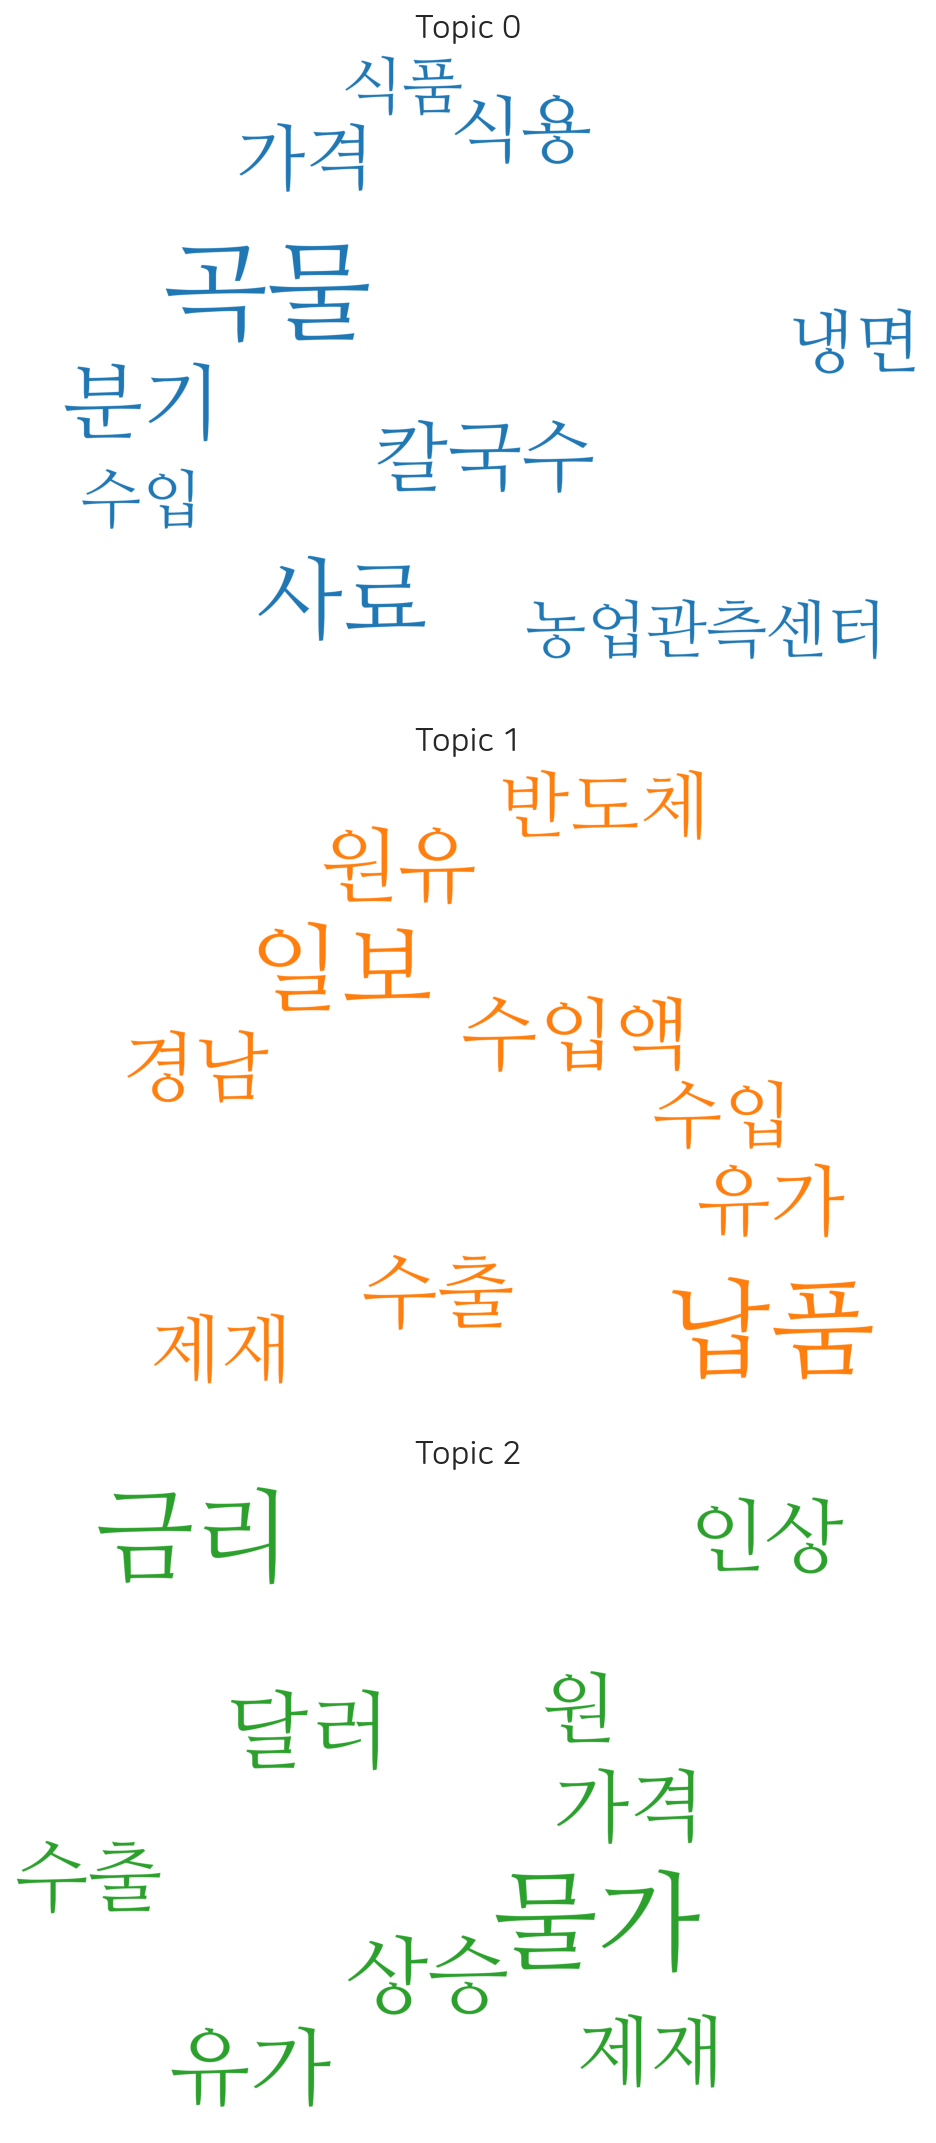

In [34]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0,
                  font_path=font_path)

topics = lda_model_3.show_topics(formatted=False)

fig, axes = plt.subplots(3, 1, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [35]:
print(lda_model_3.print_topics())

2022-04-18 07:16:59,350 : INFO : topic #0 (0.333): 0.004*"곡물" + 0.002*"사료" + 0.002*"분기" + 0.002*"칼국수" + 0.002*"식용" + 0.002*"가격" + 0.001*"냉면" + 0.001*"수입" + 0.001*"농업관측센터" + 0.001*"식품"
2022-04-18 07:16:59,353 : INFO : topic #1 (0.333): 0.001*"납품" + 0.000*"일보" + 0.000*"원유" + 0.000*"수입액" + 0.000*"수출" + 0.000*"유가" + 0.000*"경남" + 0.000*"제재" + 0.000*"반도체" + 0.000*"수입"
2022-04-18 07:16:59,355 : INFO : topic #2 (0.333): 0.003*"물가" + 0.002*"금리" + 0.002*"달러" + 0.002*"유가" + 0.002*"상승" + 0.001*"인상" + 0.001*"가격" + 0.001*"원" + 0.001*"제재" + 0.001*"수출"


[(0,
  '0.004*"곡물" + 0.002*"사료" + 0.002*"분기" + 0.002*"칼국수" + 0.002*"식용" + '
  '0.002*"가격" + 0.001*"냉면" + 0.001*"수입" + 0.001*"농업관측센터" + 0.001*"식품"'),
 (1,
  '0.001*"납품" + 0.000*"일보" + 0.000*"원유" + 0.000*"수입액" + 0.000*"수출" + '
  '0.000*"유가" + 0.000*"경남" + 0.000*"제재" + 0.000*"반도체" + 0.000*"수입"'),
 (2,
  '0.003*"물가" + 0.002*"금리" + 0.002*"달러" + 0.002*"유가" + 0.002*"상승" + 0.001*"인상" '
  '+ 0.001*"가격" + 0.001*"원" + 0.001*"제재" + 0.001*"수출"')]


In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_3, tfidf[corpus], dictionary=lda_model_3.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.079850 -0.000539       1        1  90.330740
0     -0.044229 -0.007232       2        1   6.169565
1     -0.035621  0.007771       3        1   3.499695, topic_info=     Term       Freq      Total Category  logprob  loglift
7      곡물  13.000000  13.000000  Default  30.0000  30.0000
144    분기  12.000000  12.000000  Default  29.0000  29.0000
1      가격  19.000000  19.000000  Default  28.0000  28.0000
158    수입  14.000000  14.000000  Default  27.0000  27.0000
40    밀가루   5.000000   5.000000  Default  26.0000  26.0000
...   ...        ...        ...      ...      ...      ...
748    적자   0.131432  11.084862   Topic3  -8.2744  -1.0824
25     달러   0.133699  21.176299   Topic3  -8.2573  -1.7126
645    배럴   0.110483  10.040605   Topic3  -8.4480  -1.1570
1187   금지   0.101099   6.490203   Topic3  -8.5368  -0.8095
467    동참   0.100405   8.738567   Topic3  -8.5437  -1.1138

[185 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1         1  0.917277    가격
1         2  0.050960    가격
310       1  0.998529    경기
3407      1  0.958333    경남
207       1  1.010049    경제
...     ...       ...   ...
434       1  1.031547  한국은행
112       1  0.627233  해상운임
112       2  0.627233  해상운임
548       1  1.005588    협력
1320      1  0.992871    후보

[122 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

> ### LDA 토픽 2개

In [37]:
num_topics = 2
chunksize = 2000
passes = 20
iterations = 400
eval_every = None

lda_model_2 = gensim.models.ldamodel.LdaModel(corpus=tfidf[corpus],
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            chunksize=chunksize,
                                            passes=passes,
                                            iterations=iterations,
                                            eval_every=eval_every)

2022-04-18 07:17:03,860 : INFO : using symmetric alpha at 0.5
2022-04-18 07:17:03,862 : INFO : using symmetric eta at 0.5
2022-04-18 07:17:03,872 : INFO : using serial LDA version on this node
2022-04-18 07:17:03,882 : INFO : running online (multi-pass) LDA training, 2 topics, 20 passes over the supplied corpus of 1456 documents, updating model once every 1456 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2022-04-18 07:17:05,283 : INFO : PROGRESS: pass 0, at document #1456/1456
2022-04-18 07:17:08,693 : INFO : topic #0 (0.500): 0.002*"물가" + 0.001*"가격" + 0.001*"곡물" + 0.001*"수출" + 0.001*"금리" + 0.001*"상승" + 0.001*"유가" + 0.001*"성장률" + 0.001*"달러" + 0.001*"기업"
2022-04-18 07:17:08,696 : INFO : topic #1 (0.500): 0.002*"금리" + 0.001*"물가" + 0.001*"곡물" + 0.001*"달러" + 0.001*"분기" + 0.001*"가격" + 0.001*"원" + 0.001*"수입" + 0.001*"상승" + 0.001*"중국"
2022-04-18 07:17:08,699 : INFO : topic diff=0.921242, rho=1.000000
2022-04-18 07:17:10,103 : INFO

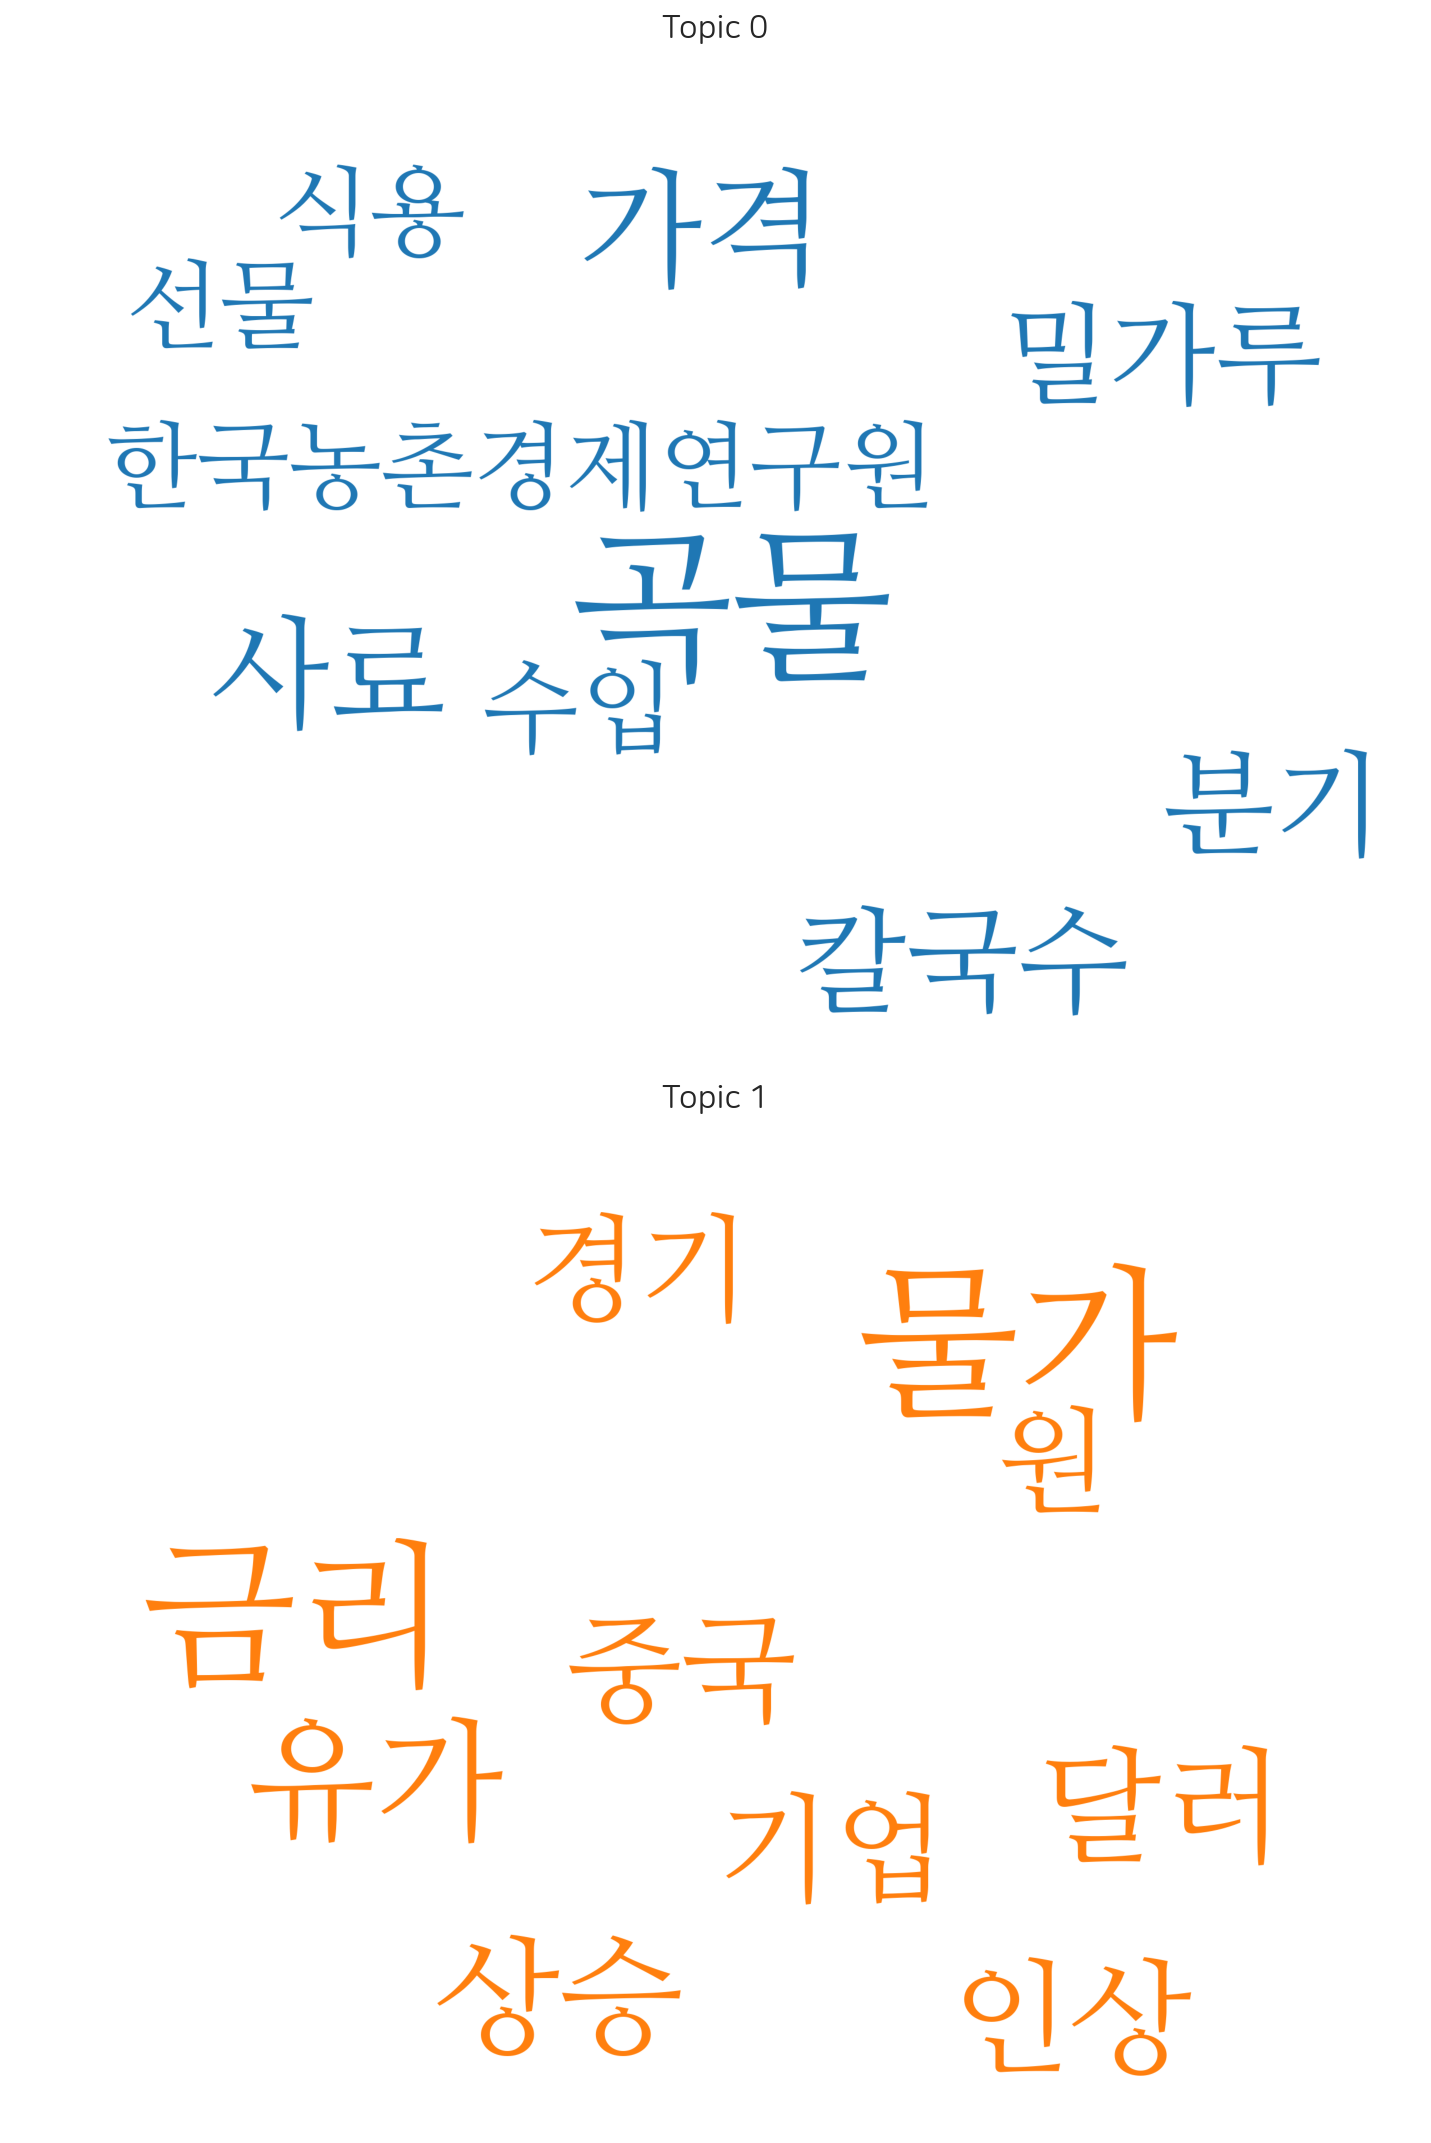

In [38]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0,
                  font_path=font_path)

topics = lda_model_2.show_topics(formatted=False)

fig, axes = plt.subplots(2, 1, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [39]:
print(lda_model_2.print_topics())

2022-04-18 07:17:53,780 : INFO : topic #0 (0.500): 0.003*"곡물" + 0.002*"가격" + 0.002*"사료" + 0.001*"칼국수" + 0.001*"분기" + 0.001*"밀가루" + 0.001*"수입" + 0.001*"식용" + 0.001*"선물" + 0.001*"한국농촌경제연구원"
2022-04-18 07:17:53,790 : INFO : topic #1 (0.500): 0.002*"물가" + 0.002*"금리" + 0.001*"유가" + 0.001*"상승" + 0.001*"달러" + 0.001*"인상" + 0.001*"중국" + 0.001*"기업" + 0.001*"경기" + 0.001*"원"


[(0,
  '0.003*"곡물" + 0.002*"가격" + 0.002*"사료" + 0.001*"칼국수" + 0.001*"분기" + '
  '0.001*"밀가루" + 0.001*"수입" + 0.001*"식용" + 0.001*"선물" + 0.001*"한국농촌경제연구원"'),
 (1,
  '0.002*"물가" + 0.002*"금리" + 0.001*"유가" + 0.001*"상승" + 0.001*"달러" + 0.001*"인상" '
  '+ 0.001*"중국" + 0.001*"기업" + 0.001*"경기" + 0.001*"원"')]


In [40]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_2, tfidf[corpus], dictionary=lda_model_2.id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.041285  0.0       1        1  89.608258
0     -0.041285  0.0       2        1  10.391742, topic_info=     Term       Freq      Total Category  logprob  loglift
7      곡물   8.000000   8.000000  Default  30.0000  30.0000
1      가격  14.000000  14.000000  Default  29.0000  29.0000
144    분기  11.000000  11.000000  Default  28.0000  28.0000
158    수입  12.000000  12.000000  Default  27.0000  27.0000
147    사료   2.000000   2.000000  Default  26.0000  26.0000
...   ...        ...        ...      ...      ...      ...
71      원   1.290648  15.470595   Topic2  -7.0783  -0.2196
86     정보   0.896724   4.332911   Topic2  -7.4425   0.6889
25     달러   0.985473  17.425564   Topic2  -7.3481  -0.6084
54     상승   0.848145  17.697963   Topic2  -7.4982  -0.7740
1037   지수   0.834280   9.199091   Topic2  -7.5146  -0.1361

[134 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2574      2  1.112177      가게
1         1  0.826745      가격
1         2  0.206686      가격
4         1  0.699956     거래소
4         2  0.349978     거래소
...     ...       ...     ...
111       2  1.130840  한국소비자원
434       1  1.040025    한국은행
435       1  0.983260      한은
112       2  0.795607    해상운임
1320      1  1.022947      후보

[131 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])